In [74]:
import os
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [75]:
import glob
annotation_file = './words_captcha/spec_train_val.txt'
IMAGE_DIR = './words_captcha/'

img_name_list = []
caption_list = []

with open(annotation_file) as f:
    for line in f:
        image_name, caption = line.strip().split()
        img_name_list.append(f'./words_captcha/{image_name}.png')
        caption_list.append('<start> ' + ' '.join(caption) + ' <end>')

test_img_name = set(glob.glob(f'./words_captcha/*.png')) - set(img_name_list)
img_name_list += sorted(test_img_name)

print(img_name_list[3])
print(caption_list[3])

./words_captcha/a3.png
<start> i d s <end>


In [76]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='', filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(caption_list)
cap_seqs = tokenizer.texts_to_sequences(caption_list)

cap_seqs = tf.keras.preprocessing.sequence.pad_sequences(cap_seqs, padding='post')
max_length = len(cap_seqs[0])

print(cap_seqs)
print(max_length)
print(caption_list[2])
print(cap_seqs[2])

[[ 2  9 18 ...  6  3  0]
 [ 2 24 24 ...  3  0  0]
 [ 2  9  8 ... 13  3  0]
 ...
 [ 2 24  5 ...  3  0  0]
 [ 2 14  5 ...  4  3  0]
 [ 2  6  8 ... 23  3  0]]
7
<start> t i e d <end>
[ 2  9  8  4 13  3  0]


In [77]:
img_name_train, img_name_valid = img_name_list[:100000], img_name_list[100000:120000]
cap_seqs_train, cap_seqs_valid = cap_seqs[:100000], cap_seqs[100000:]
img_name_test = img_name_list[120000:]

In [78]:
IMAGE_SIZE = (160, 300)

BATCH_SIZE = 100
BUFFER_SIZE = 5000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
EPOCHS = 10
num_steps = len(img_name_train) // BATCH_SIZE
learning_rate = 1e-4

In [79]:
def map_func(img_path, cap_seq):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = img / 255 * 2 - 1 #normalize image
    return img, cap_seq

In [80]:
dataset_train = tf.data.Dataset.from_tensor_slices((img_name_train, cap_seqs_train))\
                               .map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                               .shuffle(BUFFER_SIZE)\
                               .batch(BATCH_SIZE, drop_remainder=True)\
                               .prefetch(tf.data.experimental.AUTOTUNE)

dataset_valid = tf.data.Dataset.from_tensor_slices((img_name_valid, cap_seqs_valid))\
                               .map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                               .batch(BATCH_SIZE, drop_remainder=True)\
                               .prefetch(tf.data.experimental.AUTOTUNE)

In [81]:
# extract feature
from tensorflow.keras import layers

class conv_leaky_relu(layers.Layer):
    def __init__(self, filters, size, stride):
        super(conv_leaky_relu, self).__init__()
        self.conv_2d = layers.Conv2D(filters, size, stride, padding='same')
        self.batch_norm = layers.BatchNormalization()
        self.leakey_relu = layers.LeakyReLU(0.1)

    def call(self, inputs):
        x = self.conv_2d(inputs)
        x = self.batch_norm(x)
        x = self.leakey_relu(x)
        return x

In [82]:
from tensorflow.keras import Input, layers, Model

inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x = conv_leaky_relu(64, 7, 2)(inputs)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(192, 3, 1)(x)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(128, 1, 1)(x)
x = conv_leaky_relu(256, 3, 1)(x)
x = conv_leaky_relu(256, 1, 1)(x)
x = conv_leaky_relu(512, 3, 1)(x)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(256, 1, 1)(x)
x = conv_leaky_relu(512, 3, 1)(x)
x = conv_leaky_relu(256, 1, 1)(x)
x = conv_leaky_relu(512, 3, 1)(x)
x = conv_leaky_relu(256, 1, 1)(x)
x = conv_leaky_relu(512, 3, 1)(x)
x = conv_leaky_relu(256, 1, 1)(x)
x = conv_leaky_relu(512, 3, 1)(x)
x = conv_leaky_relu(512, 1, 1)(x)
x = conv_leaky_relu(1024, 3, 1)(x)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(512, 1, 1)(x)
x = conv_leaky_relu(1024, 3, 1)(x)
x = conv_leaky_relu(512, 1, 1)(x)
x = conv_leaky_relu(1024, 3, 1)(x)
x = conv_leaky_relu(1024, 3, 1)(x)
x = conv_leaky_relu(1024, 3, 2)(x)
x = conv_leaky_relu(1024, 3, 1)(x)
outputs = conv_leaky_relu(1024, 3, 1)(x)

feature_extractor = Model(inputs=inputs, outputs=outputs, name='YOLO')

In [83]:
feature_extractor.summary()

Model: "YOLO"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 300, 3)]     0         
                                                                 
 conv_leaky_relu_48 (conv_le  (None, 80, 150, 64)      9728      
 aky_relu)                                                       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 40, 75, 64)       0         
 2D)                                                             
                                                                 
 conv_leaky_relu_49 (conv_le  (None, 40, 75, 192)      111552    
 aky_relu)                                                       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 20, 37, 192)      0         
 2D)                                                          

In [84]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [85]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [86]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [87]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [88]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [89]:
# Checkpoint
checkpoint_path = './checkpoints/YOLO/'
ckpt = tf.train.Checkpoint(feature_extractor=feature_extractor,
                           encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

In [90]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [91]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [94]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    
    hidden = decoder.reset_state(batch_size=BATCH_SIZE)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)
    
    with tf.GradientTape() as tape:
        features = feature_extractor(img_tensor, True)
        features = tf.reshape(features, (features.shape[0], -1, features.shape[3]))
        features = encoder(features)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = feature_extractor.trainable_variables + encoder.trainable_variables + decoder.trainable_variables
    
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return total_loss

In [95]:
import time
from tqdm import tqdm

loss_plot = []
start = time.time()
for epoch in range(start_epoch, EPOCHS):
    loss = 0
    pbar = tqdm(dataset_train, total=num_steps, desc=f'Epoch {epoch + 1:2d}')
    for (step, (img_tensor, target)) in enumerate(pbar):
        loss += train_step(img_tensor, target)
        pbar.set_postfix({'loss': loss.numpy() / (step + 1)})

    loss_plot.append(loss / num_steps)
    ckpt_manager.save()

    # score = evaluate(dataset_valid)
    # print(f'Validation accuracy: {score:.2f}')

print('Time taken for {} epoch {} sec\n'.format(EPOCHS - start_epoch, time.time() - start))

Epoch 10: 100%|██████████████████████████████████████████████████████| 1000/1000 [08:01<00:00,  2.08it/s, loss=0.00784]


Time taken for 10 epoch 4829.953393936157 sec



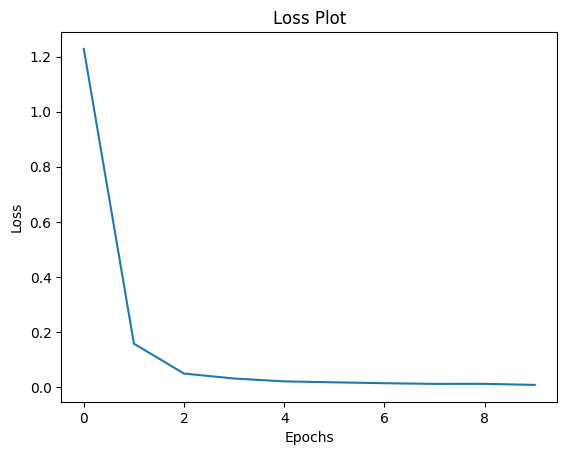

In [96]:
import matplotlib.pyplot as plt

plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [97]:
ckpt = tf.train.Checkpoint(feature_extractor=feature_extractor,
                           encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt.restore('./checkpoints/YOLO/ckpt-10')

In [98]:
import numpy as np

total_equal = 0
total_loss = 0

START = tokenizer.word_index['<start>']
END = tokenizer.word_index['<end>']

for (batch, (img_tensor, target)) in enumerate(dataset_valid):

    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    features = feature_extractor(img_tensor,False)
    features = tf.reshape(features,(features.shape[0], -1, features.shape[3]))
    features = encoder(features)

    # result = []
    result = np.full((BATCH_SIZE, 1), START)

    for i in range(1, target.shape[1]):

        # passing the features through the decoder
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        predicted_id = tf.argmax(predictions,axis=1).numpy()

        loss += loss_function(target[:, i], predictions)

        result = np.concatenate((result, predicted_id.reshape((BATCH_SIZE,1))), axis=1)

        dec_input = tf.expand_dims(predicted_id, 1)

    target_array = target.numpy()

    total_loss += (loss / int(target.shape[1]))

    for i in range(BATCH_SIZE):
        for j in range(max_length):
            if result[i][j] == END and target_array[i][j] == END:
                if (result[i][1:j] == target_array[i][1:j]).all():
                    total_equal+=1
                break

In [99]:
valid_acu = round( float(total_equal ) / (( batch + 1 ) * BATCH_SIZE ), 3)
valid_loss = round(float(total_loss / (batch + 1)), 3)
print (f'Valid Accuracy {valid_acu}, Validation Loss {valid_loss}')

Valid Accuracy 0.922, Validation Loss 0.073


In [100]:
def map_test(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = img / 255 * 2 - 1
    return img, img_path

In [101]:
dataset_test = tf.data.Dataset.from_tensor_slices((img_name_test))\
                              .map(map_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                              .batch(100)\
                              .prefetch(tf.data.experimental.AUTOTUNE)

In [102]:
print(dataset_test)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>


In [103]:
def predict(img_tensor):
    batch_size = img_tensor.shape[0]
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * batch_size, 1)

    features = feature_extractor(img_tensor)
    features = tf.reshape(features, (features.shape[0], -1, features.shape[3]))
    features = encoder(features)

    hidden = decoder.reset_state(batch_size=batch_size)

    result = tf.expand_dims([tokenizer.word_index['<start>']] * batch_size, 1)
    for _ in range(max_length):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        predicted_id = tf.argmax(predictions, axis=1).numpy()
        dec_input = tf.expand_dims(predicted_id, 1)
        result = tf.concat([result, predicted_id.reshape((batch_size, 1))], axis=1)

    return result

In [105]:
import re
output = './Lab12-2_111062678.txt'
with open(output, 'w') as fout:
    for step, (img_tensor, img_path) in enumerate(dataset_test):
        segs = predict(img_tensor).numpy();
        pred_list = []
        for seq in segs:
            result = ''
            for s in seq[1:]:
                if s == tokenizer.word_index['<end>']:
                    break
                result += tokenizer.index_word[s]
            pred_list.append(result)
        
        for path, pred in zip(img_path, pred_list):
            path = path.numpy().decode('utf-8')
            name = re.search('(a[0-9]+)', path).group(1)
            fout.write(f'{name} {pred}\n')

### Report
架構和Image Captioning一樣是透過CNN做feature extraction，再接上CNN encoder和RNN decoder，在lab中的Image Captioning 主要是focus在word，但這裡主要是透過圖片預測各個單字，因此這邊會將每個單字賦予一個編號。此處的feature extraction的架構是遵循YOLO而設計的，encoder和decoder是遵照lab上的code，在訓練過程中，我設置了10個epochs，最終利用第十個epoch的weight得到了0.922的Valid Accuracy。之後會想再試試看能不能透過置換feature extraction的CNN架構來更進一步的提升Validation Accuracy。